In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

df = pd.read_csv('DailyAvgForecast.csv')

df["obs_week_sin"] = sin_transformer(52).fit_transform(df[['observation_date_w']])["observation_date_w"]
df["obs_week_cos"] = cos_transformer(52).fit_transform(df[['observation_date_w']])["observation_date_w"]
df["obs_day_sin"] = sin_transformer(7).fit_transform(df[['observation_date_d']])["observation_date_d"]
df["obs_day_cos"] = cos_transformer(7).fit_transform(df[['observation_date_d']])["observation_date_d"]
df["del_week_sin"] = sin_transformer(52).fit_transform(df[['delivery_date_w']])["delivery_date_w"]
df["del_week_cos"] = cos_transformer(52).fit_transform(df[['delivery_date_w']])["delivery_date_w"]
df["del_day_sin"] = sin_transformer(7).fit_transform(df[['delivery_date_d']])["delivery_date_d"]
df["del_day_cos"] = cos_transformer(7).fit_transform(df[['delivery_date_d']])["delivery_date_d"]

df['total_booked_cancelation_prediction_log'] = np.log1p(df['total_booked_cancelation_prediction'])
df['total_cancelations_rs_log'] = np.log1p(df['total_cancelations_rs'])
df['running_sum_bookings_log'] = np.log1p(df['running_sum_bookings'])

ml_df = df.drop(
        ['city_destination', 'observation_date', 'delivery_date','observation_date_y','observation_date_w', 
         'observation_date_d','delivery_date_y', 'delivery_date_w', 'delivery_date_d',
         'total_booked_cancelation_prediction','total_cancelations_rs','running_sum_bookings','running_sum_bookings_log'], axis = 1
)
ml_df = ml_df.dropna()

Mean Squared Error: 177.90665976423904
R-squared: 0.9630626089838503


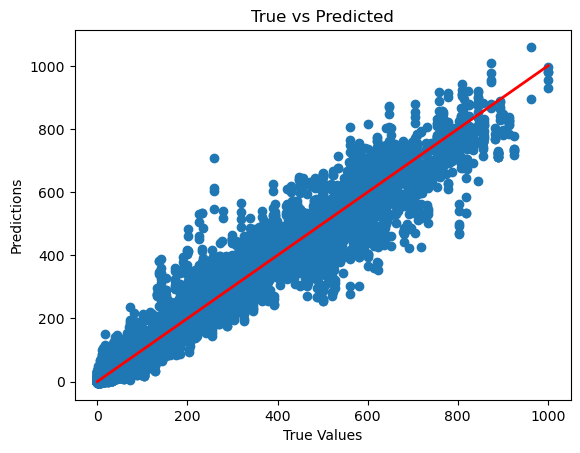

In [43]:
X = ml_df.drop(columns=['target_demanded']) 
y = ml_df['target_demanded']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
X_test['y_true'] = y_test
X_test['y_pred'] = y_pred.round()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()


Mean Squared Error: 259.7373593664631
R-squared: 0.9460727304018007


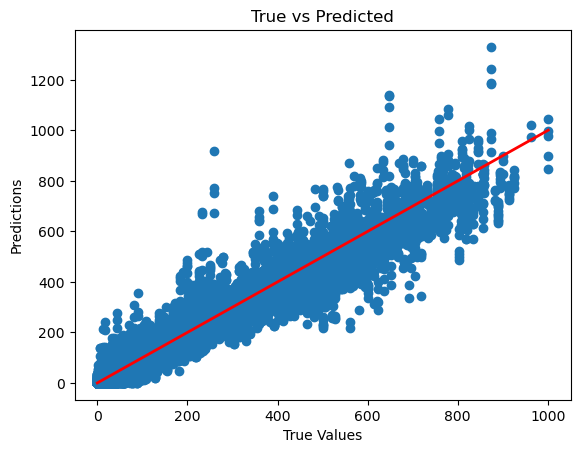

In [37]:
ml_df2 = df.dropna()

X = ml_df2[['total_booked_cancelation_prediction']]
y = ml_df2['target_demanded']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
X_test['y_true'] = y_test
X_test['y_pred'] = y_pred.round()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted')
plt.show()


<Figure size 1000x600 with 0 Axes>

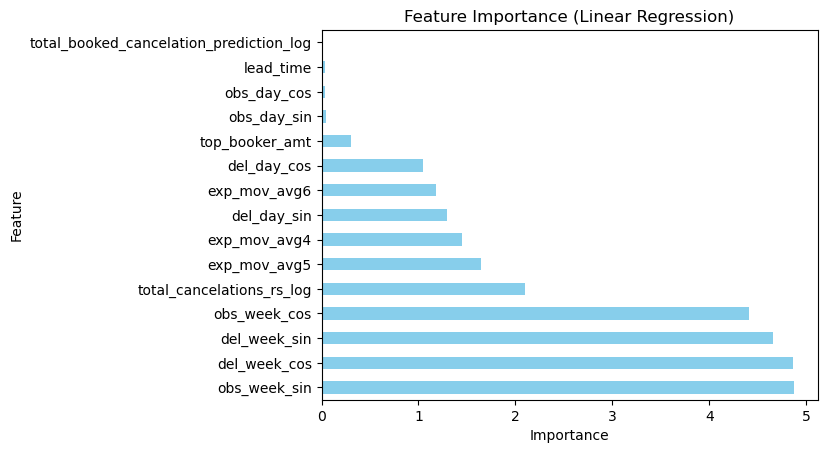

In [45]:
# Get the feature coefficients
feature_importance = abs(model.coef_)

# Create a DataFrame to display feature importance
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted features
#print(importance_df)

# Optional: Plot the feature importance
plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Feature Importance (Linear Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [47]:
from sklearn.model_selection import cross_val_score, train_test_split

cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')

# Step 4: Convert negative MSE to positive and calculate the average
cv_scores = -cv_scores  # neg_mean_squared_error returns negative scores
mean_cv_score = np.mean(cv_scores)

# Display cross-validation results
print(f"Cross-validated Mean Squared Error (MSE): {mean_cv_score:.4f}")

# If you want to display individual fold scores:
print(f"Individual Fold Scores (MSE): {cv_scores}")

Cross-validated Mean Squared Error (MSE): 179.5186
Individual Fold Scores (MSE): [175.16082343 175.89203357 187.42505074 175.65963464 182.51162655
 178.22762221 173.23731093 203.89132496 163.05671059 180.12426228]


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso as lr

model = LinearRegression()
#model = lr(alpha=1.5)

# Lists to store results
coefficients = []
mse_scores = []

tscv = TimeSeriesSplit(n_splits=10)

# Iterate over each train-test split
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Get the coefficients for this fold
    coefficients.append(model.coef_)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Convert list of coefficients into a DataFrame for easy viewing
coefficients_df = pd.DataFrame(coefficients, columns=X.columns)

# Calculate the average MSE across all folds
average_mse = np.mean(mse_scores)

# Print out the results
print(f"Average MSE across all folds: {average_mse:.4f}")
print("Coefficients for each fold:")
print(coefficients_df)


Average MSE across all folds: 176.5093
Coefficients for each fold:
   lead_time  exp_mov_avg4  exp_mov_avg5  exp_mov_avg6  running_sum_bookings  \
0   0.000830      0.479811     -0.756368      1.010240              0.314557   
1   0.010644      0.612292     -0.976613      1.095342              0.314073   
2   0.012484      0.791876     -1.158361      1.139280              0.307163   
3   0.013829      0.896373     -1.325747      1.204697              0.291721   
4   0.012763      1.041944     -1.466637      1.236923              0.303848   
5   0.015670      1.079721     -1.531909      1.262804              0.306579   
6   0.017805      1.121970     -1.567667      1.265367              0.313403   
7   0.018483      1.165657     -1.636437      1.290036              0.316335   
8   0.019780      1.192503     -1.694199      1.316214              0.332531   
9   0.020438      1.164241     -1.643564      1.293472              0.326056   

   total_cancelations_rs  top_booker_amt  obs_week_s